# Dashboards and Widgets


In [1]:
from pathlib import Path

files = Path("files")  # location of test files

In [2]:
from metador_core.plugins import schemas

BibMeta = schemas["core.bib"]
DBMeta = schemas["core.dashboard"]
ImgMeta = schemas["core.imagefile"]

In [3]:
from metador_core.plugins import harvesters
from metador_core.harvester import harvest, metadata_loader, file_harvester_pipeline

HrvFile = harvesters["core.file.generic"]
HrvImgDim = harvesters["core.imagefile.dim"]

ImgMetaLoader = metadata_loader(ImgMeta, use_sidecar=True)
image_pipeline = file_harvester_pipeline(HrvFile, HrvImgDim, ImgMetaLoader)

In [4]:
from metador_core.container import MetadorContainer
from metador_core.packer.utils import embed_file

filepath = Path("my-dashboardable-container.h5")
if filepath.is_file():
    filepath.unlink()  # otherwise might fail to overwrite if previous attempt not closed

with MetadorContainer(filepath, "w") as m:
    m.meta["core.bib"] = BibMeta.parse_file(files / "test.bibmeta.yaml")
    
    imgmeta = harvest(ImgMeta, image_pipeline(files / "test.png"))
    n = embed_file(m, "foo/bar", files / "test.png", metadata=imgmeta)
    n.meta[DBMeta] = DBMeta.show(group=1)
    
    n = embed_file(m, "pdffile", files / "test.pdf")
    n.meta[DBMeta] = DBMeta.show(group=1, priority=10)
    
    n = embed_file(m, "jsonfile", files / "test.json")
    n.meta[DBMeta] = DBMeta()
    
    n = embed_file(m, "mdfile", files / "test.md")
    n.meta[DBMeta] = DBMeta()
    
    n = embed_file(m, "htmlfile", files / "test.html")
    n.meta[DBMeta] = DBMeta.show(
        [DBMeta.widget(widget_name="core.file.text.code", group=2), DBMeta.widget(group=2)]
    )

In [5]:
from metador_core.widget.jupyter import Previewable
print(Previewable.__class__)

m = Previewable(MetadorContainer("my-dashboardable-container.h5"))

<class 'type'>


 * Serving Flask app 'metador_core.widget.jupyter.standalone'
 * Debug mode: off


PNG(str, alt_text='Sorry. Something w...)
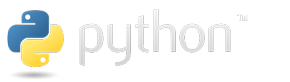

In [6]:
from metador_core.plugins import widgets

widgets["core.file.image"](m["foo/bar"]).show()

FlexBox(align_content='space-evenly', align_items='center', flex_direction='column', justify_content='space-evenly', objects=[FlexBox(align_content='sp...], sizing_mode='scale_both')
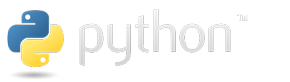

In [7]:
from metador_core.widget.dashboard import Dashboard

Dashboard(m).show()

In [8]:
m.close()  # important! or we might get file lock issues